## Create new synthetic training samples by adding small perturbations on initial training set. After creating the augmented samples, convert audio samples to log-mel spectrograms.

In [3]:
print('[INFO] import necessary packages')
import librosa
import pandas as pd
import numpy as np
from librosa import display
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import scale
import time
import unrar
import shutil
from imutils import paths
import glob

[INFO] import necessary packages


In [4]:
print('[INFO] read meta data from csv')
meta_dir = 'ESC-50-master/meta/esc50.csv'
# Load meta data for audio files
meta_data = pd.read_csv(meta_dir)
labs = meta_data.category
unique_labels = labs.unique()
meta_data.head(10)

[INFO] read meta data from csv


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


In [5]:
labels = {}
df = meta_data[['target', 'category']]
df.category.unique(),df.target.unique()
labels = dict(zip(df.target.unique(), df.category.unique()))
labels

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

In [6]:
print('[INFO]: functions to create augmented audio samples')
def add_noise(data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
def shift(data):
        return np.roll(data, 4410)
def stretch(data, rate=1):
        input_length = len(data)
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
def audio_augmentation(label,file, aug):
    directory = 'ESC-50-master/audio_augmented_data/{label}'.format(label=label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    librosa.output.write_wav(directory+'/'+ file, y = aug, sr= 44100)

[INFO]: functions to create augmented audio samples


In [ ]:
print('[INFO] generate augmented audio files')
directory_path = 'ESC-50-master/sorted_data/'
for i in range(len(labels)):
    label = labels[i]
    audio_path = os.path.join(directory_path, label)
    # randomly taking 4 audio files and create 3 augmented samples per soundfile
    path_ = np.random.choice(os.listdir(audio_path), size = (4,), replace= False)
    for k,files in zip(range(len(path_)), path_):
        data_, fs = librosa.load(os.path.join(audio_path, files), sr = 44100)
        noise_data = add_noise(data_)
        shift_data = shift(data_)
        stretch_data = stretch(data_, rate= 1.2)
        aug = [noise_data, shift_data, stretch_data]
        for j in range(len(aug)):
            filename = ('generated'+'-'+str(label)+str(k)+str(j)+'.wav')
            audio_augmentation(label ,file=filename, aug = aug[j])

In [7]:
print('[INFO] function to create log-scaled mel spectogram and save the images')
def save_log_mel_spectogram( audioPath,files, label, sampling_rate=44100):
    data, sr = librosa.load(audioPath, sr=sampling_rate, mono=True)
    # since the length of sound file is just 5secs, I'm doubling the length of sound
    data = np.append(data,data)
    data = scale(data)

    melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    # Convert to log scale (dB) using the peak power (max) as reference
        # per suggestion from Librbosa: https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html
    log_melspec = librosa.power_to_db(melspec, ref=np.max)  
    librosa.display.specshow(log_melspec, sr=sr)
    
    # create saving directory
    directory = 'ESC-50-master/processed_data/{label}'.format(label=label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig(directory + '/' + files.strip('.wav') + '.png')

[INFO] function to create log-scaled mel spectogram and save the images


In [ ]:
print('[INFO]: Creating spectorgrams')
augmented_data_directory_path = 'ESC-50-master/audio_augmented_data/'
for i in range(50):
    path = os.path.join(augmented_data_directory_path, labels[i])
    for files in os.listdir(path):
        audioPath = os.path.join(path, files)
        label = labels[i]
        save_log_mel_spectogram(audioPath,files, label, sampling_rate= 44100)

[INFO]: visualisation


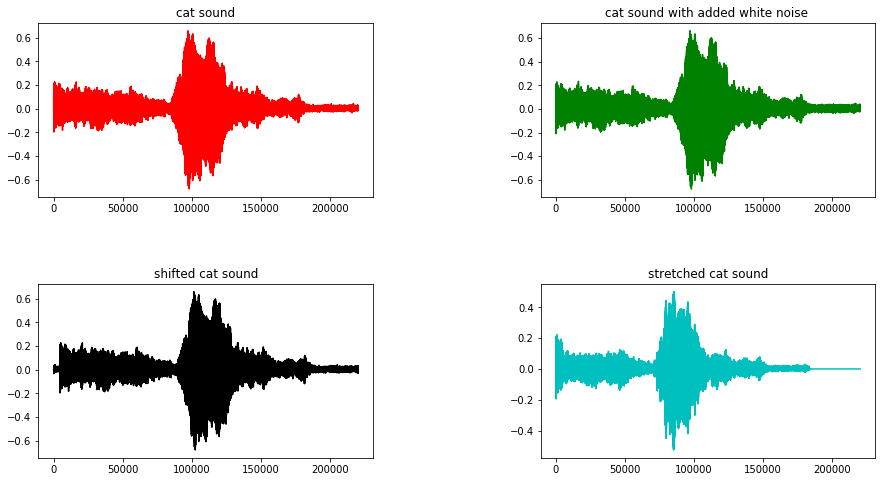

In [9]:
print('[INFO]: visualisation')
import matplotlib.pyplot as plt
data_directory_path_cat = 'ESC-50-master/sorted_data/cat/'
path_ = []
for files in os.listdir(data_directory_path_cat):
    path_.append(os.path.join(data_directory_path_cat, files))
data_, sr = librosa.load(path_[0], sr=44100, mono=True)
    #augmeted functions
noise_data = add_noise(data_)
shift_data = shift(data_)
stretch_data = stretch(data_, rate= 1.2)
   
plt.figure(1, figsize=(15,8))
plt.subplot(221)
plt.plot(data_, 'r-')
plt.title('cat sound')
    
plt.subplot(222)
plt.plot(noise_data,'g-', )
plt.title('cat sound with added white noise ')
    
plt.subplot(223)
plt.plot(shift_data,'k-', )
plt.title('shifted cat sound')
    
plt.subplot(224)
plt.plot(stretch_data,'c-', )
plt.title('stretched cat sound')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()    

